# Johnson - Week 2: K Nearest Neighbors (KNN)

**Objective:** Predict heart disease in patients.

* Get to know your data, start out by data exploration. Summarized your finding.
* Divide the data into training set and test set randomly with ratio 80:20.
  Make prediction based on 1-nearest neighbor.
  What is the error rate of this approach? Report your results in a confusion matrix.
* Use different values for K, what is the optimal value of K from your experiments?
  Report the error rate of the optimal K value and its confusion matrix.
  Is there any improvement (by how much) over 1-nearest neighbor?
* Is there anything else you can do to improve your model?
  If yes, demonstrate your approach.
  (Hint: there is always something that you can try, unless your accuracy score is 100%)

---

# 1 Setup

## 1.A Sanity Check of Provided Data File

Prior to importing any data, we perform a few checks against the file:
* What is the approximate size of the file (will our current configuration
  support the given quantity of data)?
* What is the content of the file and does it use the correct line endings?
* How many rows (lines) are in the file (can be used to double-check that
  the full dataset is loaded by Pandas)?
* Does the data have a header row?

**NOTE:** This week, we were provided an already-cleaned set of data from Week 1

In [1]:
%%bash
declare -a DATA_FILES=("data/heart.disease.data.clean.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

data/heart.disease.data.clean.csv:
    Data file size:      12K
    Data file type:      CSV text
    Number of lines:     283
    Data header row?     age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,thalach,exang,thal,num


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.compose
import sklearn.decomposition
import sklearn.impute
import sklearn.metrics
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors


# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.set_option('max_row', 100)

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED = 42
MAX_K       = 50
KNN_KWARGS  = {
    'weights':      'distance',     # 'distance', 'uniform'
    'metric':       'minkowski',    # 'minkowski', 'euclidean', 'manhanttan', 'mahalanobis'
    'p':            2,              # if metric == 'minkowski'
}

## 1.C Import the Data

* Recall from **1.A** that the file has 283 lines, so we expect
  `df_rows = 283 - 1 = 282` (because we also know the file contains a header
  row)
* Also from **1.A**, we know that there are `14` columns, based on the number
  of labels in the header row (it seems that `dm` has been removed, likely
  because it did not contain enough data to be imputed)


In [3]:
heart_disease_df = pd.read_csv('data/heart.disease.data.clean.csv')
LOGGER.info(f'heart_disease_df.shape ==> {heart_disease_df.shape[0]} rows x {heart_disease_df.shape[1]} cols')
heart_disease_df.head()

2022-01-23 03:33:28 - INFO   -   MSDS-680 - heart_disease_df.shape ==> 282 rows x 14 cols


,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,thalach,exang,thal,num
0,63,1,1,145,233,50.0,20.0,1,1,2,150,0,6,0
1,67,1,4,160,286,40.0,40.0,0,1,2,108,1,3,2
2,67,1,4,120,229,20.0,35.0,0,1,2,129,1,7,1
3,37,1,3,130,250,0.0,0.0,0,1,0,187,0,3,0
4,41,0,2,130,204,0.0,0.0,0,1,2,172,0,3,0


## 1.D Setup Conclusion

The data file is successfully imported into a Pandas data frame.  We know that
we've loaded every line and we have the correct number of columns.

Beyond that, though, we cannot assume the accuracy of the content until we
perform EDA (which we are now ready for).

# 2 Exploratory Data Analysis

## 2.A Boolean Dependent Variable

Per this week's assignment hints, we can categorize the dependent variable
(`num`) into 2 classes based on heart disease condition:

0. heart condition not detected
1. heart condition detected

In [4]:
heart_disease_df["num"] = np.where(heart_disease_df["num"] > 0, 1, 0)

heart_disease_df.head()

,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,thalach,exang,thal,num
0,63,1,1,145,233,50.0,20.0,1,1,2,150,0,6,0
1,67,1,4,160,286,40.0,40.0,0,1,2,108,1,3,1
2,67,1,4,120,229,20.0,35.0,0,1,2,129,1,7,1
3,37,1,3,130,250,0.0,0.0,0,1,0,187,0,3,0
4,41,0,2,130,204,0.0,0.0,0,1,2,172,0,3,0


# 3 K Nearest Neighbors (KNN)

## 3.A. Train / Test Split

For this exercise, we were advised to split our data 80:20 for training vs
test.  For this, we utilize the `sklearn.model_selection.train_test_split`
function.  But first, we need to separate the data into `X` (inputs) and
`y` (labels).

In [5]:
# Identify the label column:
label_column = 'num'

# All other columns are inputs (features)
feature_columns = [c for c in heart_disease_df.columns if c != label_column]

# X = input, y = labels
X = heart_disease_df[feature_columns].values
y = heart_disease_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


LOGGER.info(f'X_train.shape ==> {X_train.shape[0]} rows x {X_train.shape[1]} cols')
LOGGER.info(f'X_test.shape  ==> {X_test.shape[0]}  rows x {X_test.shape[1]} cols')

LOGGER.info(f'y_train.shape ==> {y_train.shape[0]} rows')
LOGGER.info(f'y_test.shape  ==> {y_test.shape[0]}  rows')


2022-01-23 03:33:28 - INFO   -   MSDS-680 - X_train.shape ==> 225 rows x 13 cols
2022-01-23 03:33:28 - INFO   -   MSDS-680 - X_test.shape  ==> 57  rows x 13 cols
2022-01-23 03:33:28 - INFO   -   MSDS-680 - y_train.shape ==> 225 rows
2022-01-23 03:33:28 - INFO   -   MSDS-680 - y_test.shape  ==> 57  rows


## 3.B Pipeline Preparation

We use `sklearn.pipeline.Pipeline` to create repeatable processing steps.

Our initial Pipeline is fairly simple:

* We apply scaling for continuous values, in order to prevent large values from
  overwhelming smaller values
* We one-hot encode categorical values which have no ordinal relationship

In [6]:
NUMERICAL_COLUMNS = ['age', 'trestbps', 'chol', 'cigs', 'years', 'thalach']
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'famhist', 'restecg', 'exang', 'thal']

pipeline = sklearn.pipeline.Pipeline([
    (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[
        (f'Scaler',  sklearn.preprocessing.MinMaxScaler(),  [heart_disease_df.columns.tolist().index(c) for c in NUMERICAL_COLUMNS]),
        (f'Encoder', sklearn.preprocessing.OneHotEncoder(), [heart_disease_df.columns.tolist().index(c) for c in CATEGORICAL_COLUMNS])
    ], remainder='passthrough')),
])

# Fit all the transformations **using the training data**
_ = pipeline.fit(X_train)

## 3.C KNN with `k=1`

Now that the Pipeline has been fitted, we ...

1. Transform the data using the learned values for the MinMaxScaler and OneHotEncoder
   (these values are now part of the Pipeline's internal state)
2. Create and fit the KNN model, *using the transformed data*
3. Use the (transformed) test data to predict labels *for previously unseen data*
4. Print some performance metrics    
   * Precision: positive predictive value, the ability of the classifier not to
     label as positive a sample that is negative (Scikit-Learn.org,  n.d. b)   
     $Precision = \frac{True Positives}{True Positives + False Positives}$

   * Recall: sensitivity, the ability of the classifier to find all the positive
     samples (Scikit-Learn.org, n.d. c)    
     $Recall = \frac{True Positives}{True Positives + False Negatives}$

   * F1 Score: harmonic mean of the precision and recall
     (Scikit-Learn.org, n.d. a)    
     $F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall}$

5. Display the confusion matrix for our current model's performance

2022-01-23 03:33:28 - INFO   -   MSDS-680 - When k= 1 ... Precision: 82.14%.  Recall: 82.14%.  F1 Score: 82.14%


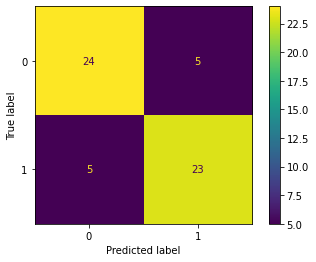

In [7]:
# 1. Transform the input values (both train and test)
Xt_train = pipeline.transform(X_train)
Xt_test  = pipeline.transform(X_test)


# 2. Create and fit the KNN model (with k=1)
CHOSEN_K=1
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=CHOSEN_K, **KNN_KWARGS)
model.fit(Xt_train, y_train)


# 3. Predict labels for previously unseen data
y_pred = model.predict(Xt_test)


# 4. Print performance metrics
precision   = sklearn.metrics.precision_score(y_test, y_pred)
recall      = sklearn.metrics.recall_score(y_test, y_pred)
f1          = sklearn.metrics.f1_score(y_test, y_pred)

LOGGER.info(f'When k={CHOSEN_K:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')


# 5. Display the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=y_pred)


As seen from the score metrics and the confusion matrix, with `k=1` the
KNeighborsClassifier achieves a precision score of `82.1%` and a recall score of
`82.1%`, for a F1 score of `82.1%`.

## 3.D Different Values for `k`

Below, we test a variety of values for `k`

2022-01-23 03:33:29 - INFO   -   MSDS-680 - Best k= 1 ... Precision: 82.14%.  Recall: 82.14%.  F1: 82.14%.  Silhouette: 0.19


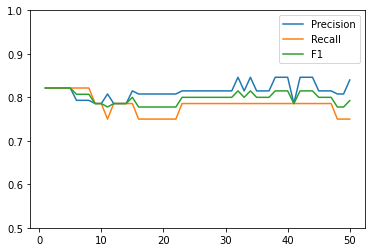

In [8]:
accuracy_df = pd.DataFrame(columns=['k', 'precision', 'recall', 'f1', 'silhouette'])

for i in range(MAX_K):
    k = i + 1
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, **KNN_KWARGS)
    model.fit(Xt_train, y_train)

    y_pred = model.predict(Xt_test)

    precision   = sklearn.metrics.precision_score(y_test, y_pred)
    recall      = sklearn.metrics.recall_score(y_test, y_pred)
    f1          = sklearn.metrics.f1_score(y_test, y_pred)
    silhouette  = sklearn.metrics.silhouette_score(Xt_test, y_pred, random_state=RANDOM_SEED)

    accuracy_df = accuracy_df.append({
        'k':            k,
        'precision':    precision,
        'recall':       recall,
        'f1':           f1,
        'silhouette':   silhouette
        }, ignore_index=True)

    LOGGER.debug(f'When k={k:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

CHOSEN_K, precision, recall, f1, _ = accuracy_df[accuracy_df.f1 == accuracy_df.f1.max()].head(1).values[0]
CHOSEN_K=int(CHOSEN_K)

LOGGER.info(f'Best k={CHOSEN_K:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

for score_type in ['precision', 'recall', 'f1']:
    plt.plot(accuracy_df.k, accuracy_df[score_type], label=score_type.title())

plt.ylim([0.5, 1])
plt.legend()


As seen from the logging output and from the graph above, a value of `k=1` (or
up to `k=5`) achieves the best F1 score.  We don't re-display the confusion matrix
since the selected `k` value did not change.

# 4 Model Improvement

## 4.A Principal Component Analysis (PCA)

Let's see if we can improve the model's performance using PCA.

### 4.A.1 Determine Optimal Number of Components

First, we perform PCA using all components and determine the number of
components which account for the majority of variance.


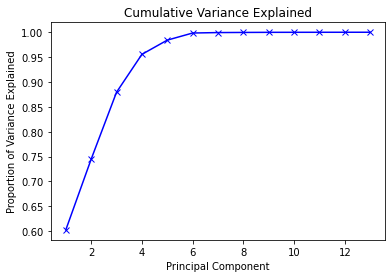

In [9]:
pca = sklearn.decomposition.PCA(random_state=RANDOM_SEED)

pca_X = pca.fit_transform(X_train)

pca_df = pd.DataFrame(pca_X)

pc_values = np.arange(pca.n_components_) + 1
plt.plot(pc_values, pca.explained_variance_ratio_.cumsum(), 'bx-')
plt.title('Cumulative Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

### 4.A.2 Use PCA to Select New `k`

Based on the analysis above, we can account for almost 100% of the variance with
just 6 principal components (a feature reduction of ~50%).

But, utilizing these new components might require selecting a new `k`.  Let's
re-run our `k` selection process.

Once we've found a new `k` (if necessary), let's also display its confusion
matrix.

2022-01-23 03:33:30 - INFO   -   MSDS-680 - Best k=11 ... Precision: 82.14%.  Recall: 82.14%.  F1: 82.14%.  Silhouette: 0.25


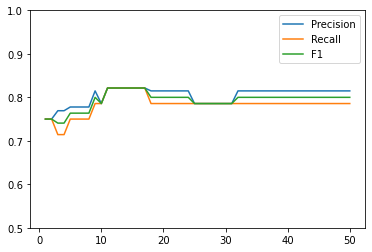

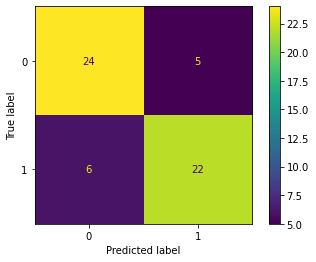

In [10]:
NUM_PCA_COMPONENTS=6

pipeline = sklearn.pipeline.Pipeline([
    (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[
        (f'Scaler',  sklearn.preprocessing.MinMaxScaler(),  [heart_disease_df.columns.tolist().index(c) for c in NUMERICAL_COLUMNS]),
        (f'Encoder', sklearn.preprocessing.OneHotEncoder(), [heart_disease_df.columns.tolist().index(c) for c in CATEGORICAL_COLUMNS])
    ], remainder='passthrough')),
    (f'PCA', sklearn.decomposition.PCA(n_components=NUM_PCA_COMPONENTS, random_state=RANDOM_SEED))
])

_ = pipeline.fit(X_train)

Xt_train = pipeline.transform(X_train)
Xt_test  = pipeline.transform(X_test)

accuracy_df = pd.DataFrame(columns=['k', 'precision', 'recall', 'f1', 'silhouette'])

best_f1_score   = -100
best_k_y_pred   = None

for i in range(MAX_K):
    k = i + 1
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, **KNN_KWARGS)
    model.fit(Xt_train, y_train)

    y_pred = model.predict(Xt_test)

    precision   = sklearn.metrics.precision_score(y_test, y_pred)
    recall      = sklearn.metrics.recall_score(y_test, y_pred)
    f1          = sklearn.metrics.f1_score(y_test, y_pred)
    silhouette  = sklearn.metrics.silhouette_score(Xt_test, y_pred, random_state=RANDOM_SEED)

    if f1 > best_f1_score:
        best_f1_score   = f1
        best_k_y_pred   = y_pred

    accuracy_df = accuracy_df.append({
        'k':            k,
        'precision':    precision,
        'recall':       recall,
        'f1':           f1,
        'silhouette':   silhouette
        }, ignore_index=True)

    LOGGER.debug(f'When k={k:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

CHOSEN_K, precision, recall, f1, _ = accuracy_df[accuracy_df.f1 == accuracy_df.f1.max()].head(1).values[0]
CHOSEN_K=int(CHOSEN_K)

LOGGER.info(f'Best k={CHOSEN_K:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

for score_type in ['precision', 'recall', 'f1']:
    plt.plot(accuracy_df.k, accuracy_df[score_type], label=score_type.title())

plt.ylim([0.5, 1])
plt.legend()

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=y_pred)


That was a lot of work to end up with the same F1 score of `82.1%`.

Addional analysis would be required to determine if the efficiency gained through
dimensionality reduction would offset the need to now compute `11` neighbors.

## 4.B Additional Feature Engineering

As part of last week's data analysis, we performed banding of `age`, `cigs`,
and `years`.  We also calculated `delta_thalach` using a formula based on
`thalach` and `age`.

We apply those changes here as well, but we apply the changes to a
*copy of the Data Frame* so that we can assess our changes without impacting
the provided DataFrame

In [11]:
modified_heart_disease_df = heart_disease_df.copy()

# Calculate `delta_thalach` from the max heart rate formula based on age
modified_heart_disease_df['delta_thalach'] = modified_heart_disease_df['thalach'] - 220 + modified_heart_disease_df['age']
modified_heart_disease_df.drop(columns=['thalach'], inplace=True)

# Convert age to bands
modified_heart_disease_df.loc[ modified_heart_disease_df['age'] <= 34, 'age'] = 0
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  34) & (modified_heart_disease_df['age'] <= 39), 'age'] = 1
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  39) & (modified_heart_disease_df['age'] <= 43), 'age'] = 2
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  43) & (modified_heart_disease_df['age'] <= 48), 'age'] = 3
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  48) & (modified_heart_disease_df['age'] <= 53), 'age'] = 4
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  53) & (modified_heart_disease_df['age'] <= 58), 'age'] = 5
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  58) & (modified_heart_disease_df['age'] <= 63), 'age'] = 6
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  63) & (modified_heart_disease_df['age'] <= 67), 'age'] = 7
modified_heart_disease_df.loc[(modified_heart_disease_df['age'] >  67) & (modified_heart_disease_df['age'] <= 72), 'age'] = 8
modified_heart_disease_df.loc[ modified_heart_disease_df['age'] >  72, 'age'] = 9

# Convert cigs to bands
modified_heart_disease_df.loc[ modified_heart_disease_df['cigs'] ==  0, 'cigs'] = 0
modified_heart_disease_df.loc[(modified_heart_disease_df['cigs'] >   0) & (modified_heart_disease_df['cigs'] <= 10), 'cigs'] = 1
modified_heart_disease_df.loc[(modified_heart_disease_df['cigs'] >  10) & (modified_heart_disease_df['cigs'] <= 20), 'cigs'] = 2
modified_heart_disease_df.loc[ modified_heart_disease_df['cigs'] >  20, 'cigs'] = 3

# Convert years to bands
modified_heart_disease_df.loc[ modified_heart_disease_df['years'] ==  0, 'years'] = 0
modified_heart_disease_df.loc[(modified_heart_disease_df['years'] >   0) & (modified_heart_disease_df['years'] <= 10), 'years'] = 1
modified_heart_disease_df.loc[(modified_heart_disease_df['years'] >  10) & (modified_heart_disease_df['years'] <= 20), 'years'] = 2
modified_heart_disease_df.loc[(modified_heart_disease_df['years'] >  20) & (modified_heart_disease_df['years'] <= 30), 'years'] = 3
modified_heart_disease_df.loc[(modified_heart_disease_df['years'] >  30) & (modified_heart_disease_df['years'] <= 40), 'years'] = 4
modified_heart_disease_df.loc[ modified_heart_disease_df['years'] >  40, 'years'] = 5

cols_at_end = ['num']
modified_heart_disease_df = modified_heart_disease_df[[c for c in modified_heart_disease_df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in modified_heart_disease_df]]

modified_heart_disease_df.head()

,age,sex,cp,trestbps,chol,cigs,years,fbs,famhist,restecg,exang,thal,delta_thalach,num
0,6,1,1,145,233,3.0,2.0,1,1,2,0,6,-7,0
1,7,1,4,160,286,3.0,4.0,0,1,2,1,3,-45,1
2,7,1,4,120,229,2.0,4.0,0,1,2,1,7,-24,1
3,1,1,3,130,250,0.0,0.0,0,1,0,0,3,4,0
4,2,0,2,130,204,0.0,0.0,0,1,2,0,3,-7,0


In [12]:
# Identify the label column:
label_column = 'num'

# All other columns are inputs (features)
feature_columns = [c for c in modified_heart_disease_df.columns if c != label_column]

# Xm = input from modified DF, ym = labels from modified DF
Xm = modified_heart_disease_df[feature_columns].values
ym = modified_heart_disease_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
Xm_train, Xm_test, ym_train, ym_test = sklearn.model_selection.train_test_split(Xm, ym, test_size=0.2, random_state=RANDOM_SEED)


LOGGER.info(f'Xm_train.shape ==> {Xm_train.shape[0]} rows x {Xm_train.shape[1]} cols')
LOGGER.info(f'Xm_test.shape  ==> {Xm_test.shape[0]}  rows x {Xm_test.shape[1]} cols')

LOGGER.info(f'ym_train.shape ==> {ym_train.shape[0]} rows')
LOGGER.info(f'ym_test.shape  ==> {ym_test.shape[0]}  rows')


2022-01-23 03:33:30 - INFO   -   MSDS-680 - Xm_train.shape ==> 225 rows x 13 cols
2022-01-23 03:33:30 - INFO   -   MSDS-680 - Xm_test.shape  ==> 57  rows x 13 cols
2022-01-23 03:33:30 - INFO   -   MSDS-680 - ym_train.shape ==> 225 rows
2022-01-23 03:33:30 - INFO   -   MSDS-680 - ym_test.shape  ==> 57  rows


2022-01-23 03:33:31 - INFO   -   MSDS-680 - Best k= 4 ... Precision: 85.19%.  Recall: 82.14%.  F1: 83.64%.  Silhouette: 0.18


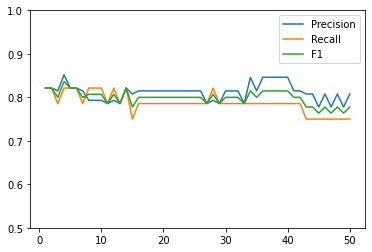

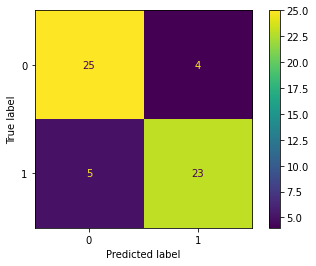

In [13]:
# Even though age, cigs, and years are banded, they are still ordinal
NUMERICAL_COLUMNS   = ['age', 'trestbps', 'chol', 'cigs', 'years', 'delta_thalach']
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'famhist', 'restecg', 'exang', 'thal']

pipeline = sklearn.pipeline.Pipeline([
    (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[
        (f'Scaler',  sklearn.preprocessing.MinMaxScaler(),  [modified_heart_disease_df.columns.tolist().index(c) for c in NUMERICAL_COLUMNS]),
        (f'Encoder', sklearn.preprocessing.OneHotEncoder(), [modified_heart_disease_df.columns.tolist().index(c) for c in CATEGORICAL_COLUMNS])
    ], remainder='passthrough')),
])

# Fit all the transformations **using the training data**
_ = pipeline.fit(Xm_train)

Xmt_train = pipeline.transform(Xm_train)
Xmt_test  = pipeline.transform(Xm_test)
accuracy_df = pd.DataFrame(columns=['k', 'precision', 'recall', 'f1', 'silhouette'])

best_f1_score = -100
best_k_ym_pred = None

for i in range(MAX_K):
    k = i + 1
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, **KNN_KWARGS)
    model.fit(Xmt_train, ym_train)

    ym_pred = model.predict(Xmt_test)

    precision   = sklearn.metrics.precision_score(ym_test, ym_pred)
    recall      = sklearn.metrics.recall_score(ym_test, ym_pred)
    f1          = sklearn.metrics.f1_score(ym_test, ym_pred)
    silhouette  = sklearn.metrics.silhouette_score(Xmt_test, ym_pred, random_state=RANDOM_SEED)

    if f1 > best_f1_score:
        best_f1_score   = f1
        best_k_ym_pred  = ym_pred

    accuracy_df = accuracy_df.append({
        'k':            k,
        'precision':    precision,
        'recall':       recall,
        'f1':           f1,
        'silhouette':   silhouette
        }, ignore_index=True)

    LOGGER.debug(f'When k={k:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

CHOSEN_K, precision, recall, f1, _ = accuracy_df[accuracy_df.f1 == accuracy_df.f1.max()].head(1).values[0]
CHOSEN_K=int(CHOSEN_K)

LOGGER.info(f'Best k={CHOSEN_K:>2d} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1: {f1:.2%}.  Silhouette: {silhouette:.2}')

for score_type in ['precision', 'recall', 'f1']:
    plt.plot(accuracy_df.k, accuracy_df[score_type], label=score_type.title())

plt.ylim([0.5, 1])
plt.legend()

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=best_k_ym_pred)


# 5 Summary

Through aggressive feature engineering, we achieved a slight improvement
in `F1` score from `82.1%` to `83.6%`.  Further analysis would be required
to pinpoint the true source of the improvement, but my guess would be the
`delta_thalach` column.  My reasoning is that the banding simplifies the
features but does not provide new information, whereas the `delta_thalach`
combines two features using a formula that has independently been proven to
provide the target heart rate for a specific age.

# References

Scikit-Learn.org (n.d. a).  sklearn.metrics.f1_score.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Scikit-Learn.org (n.d. b).  sklearn.metrics.precision_score.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score

Scikit-Learn.org (n.d. c).  sklearn.metrics.recall_score.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score

